In [4]:
import openmc
import numpy as np

In [5]:
BISO_KERNEL_RADIUS   = 0.04 # cm  # r = 400 μm = 0.0400 cm // "800 μm kernel"
BISO_RADIUS          = 0.05 # cm  # r = 500 μm = 0.0500 cm // "100 μm thickness"
BISO_VOLUME          = (4 / 3) * np.pi * (BISO_RADIUS)**3            # volume of single BISO particle
KERNEL_VOLUME        = (4 / 3) * np.pi * (BISO_KERNEL_RADIUS)**3     # volume of UO2/ThO2 kernel in single BISO particle
BISO_KERNEL_VOL_FRAC = KERNEL_VOLUME / BISO_VOLUME  # vol frac kernel in single BISO
BISO_COAT_VOL_FRAC   = 1.0 - BISO_KERNEL_VOL_FRAC

In [6]:
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=0.71)  
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.5)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.2)

# FLiBe
breeder = openmc.Material(name='FLiBe', temperature=900)
breeder.add_elements_from_formula('F4Li2Be', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=20)
breeder.set_density('g/cm3', 1.94) 

materials = openmc.Materials([uo2, sic, breeder])
materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

In [7]:
# UO2 kernel sphere (radius = 0.04 cm)
kernel_outer = openmc.Sphere(r=BISO_KERNEL_RADIUS)

# SiC coating outer surface (radius = 0.04 + 0.01 = 0.05 cm)
sic_outer = openmc.Sphere(r=BISO_RADIUS)

# Reflective cube boundaries 
biso_vol_frac = 0.50 # 0.01 # 0.50
cube_length = ((4/3 * np.pi * BISO_RADIUS**3)/biso_vol_frac)**(1/3)
cube_half   = cube_length / 2
print(f"cube length = {cube_length:.4f} cm")

# cube_length = 0.374  # cm for BISO particle to be  1% vol # = ((4/3(pi)(0.05)^3)/0.01)^(1/3) = 0.37411019268
# cube_length = 0.102  # cm for BISO particle to be 50% vol # = ((4/3(pi)(0.05)^3)/0.5)^(1/3) = 0.10154912975

x_min = openmc.XPlane(-cube_half, boundary_type='periodic')
x_max = openmc.XPlane( cube_half, boundary_type='periodic')
y_min = openmc.YPlane(-cube_half, boundary_type='periodic')
y_max = openmc.YPlane( cube_half, boundary_type='periodic')
z_min = openmc.ZPlane(-cube_half, boundary_type='periodic')
z_max = openmc.ZPlane( cube_half, boundary_type='periodic')
x_min.periodic_surface = x_max
y_min.periodic_surface = y_max
z_min.periodic_surface = z_max

# UO2 kernel
cell_kernel = openmc.Cell(name='UO2')
cell_kernel.fill = uo2
cell_kernel.region = -kernel_outer

# SiC coating
cell_sic = openmc.Cell(name='SiC')
cell_sic.fill = sic
cell_sic.region = +kernel_outer & -sic_outer

# FLiBe
cell_breeder = openmc.Cell(name='FLiBe')
cell_breeder.fill = breeder
cell_breeder.region = +sic_outer & +x_min & -x_max & +y_min & -y_max & +z_min & -z_max

# Create universe and geometry
root_universe = openmc.Universe(cells=[cell_kernel, cell_sic, cell_breeder])
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

cube length = 0.1015 cm


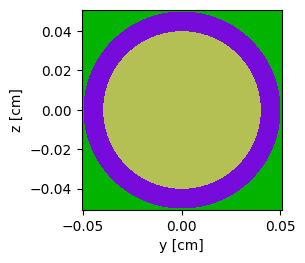

In [8]:
img = geometry.plot(basis='yz',                           # slice plane
                    width=(cube_length, cube_length),     # cm window
                    pixels=(200, 200),
                    color_by='material')

In [9]:
settings = openmc.Settings()

""" First wall neutron spectrum """
# Flux spectrum from neutrons leaving the surface of a 1-cm V first wall
sp = openmc.StatePoint(f'./FirstWall_V1cm_900K_2025-07-22/statepoint.100.h5')
out_tally = sp.get_tally(name='outgoing_spectrum')

energy_bins = np.array(out_tally.filters[1].bins) # shape (N, 2)
energy_midpoints = 0.5 * (energy_bins[:, 0] + energy_bins[:, 1])

current_spectrum = out_tally.get_values(scores=['current']).flatten() # Neutron generation at each current in the spectrum is weighted by its probability of occurrence
total_current = current_spectrum.sum()
probabilities = current_spectrum / total_current
energies, weights = energy_midpoints.tolist(), probabilities.tolist()

"""Source: 14 MeV"""
source = openmc.IndependentSource()
source.space = openmc.stats.Box([-1*cube_half, -1*cube_half, -1*cube_half], [cube_half, cube_half, cube_half])
source.particle = 'neutron'
source.constraints = {'fissionable': False}
source.energy = openmc.stats.Discrete(energies, weights) # openmc.stats.Discrete([14.0e6], [1.0])  # 14 MeV
# source.angle    = openmc.stats.Monodirectional((1, 0, 0))
source.angle = openmc.stats.Isotropic()


"""Settings"""
settings.run_mode  = "fixed source"
settings.batches   = 10
settings.particles = int(1e4)
settings.source    = [source]
# settings.write_initial_source = True
settings.volume_normalized_flux_tallies = True
# settings.sourcepoint = {'batches':[10],'write':True}

In [10]:
"""Tallies: region split + 1D centerline mesh"""
tallies = openmc.Tallies()

cell_filter = openmc.CellFilter([cell_kernel, cell_sic, cell_breeder])

# 2d mesh tally
mesh2d = openmc.RegularMesh()
mesh2d.dimension = [100, 100]                  
mesh2d.lower_left = [-cube_half, -cube_half]  # If only two coordinate are given, it is assumed that the mesh is an x-y mesh.
mesh2d.upper_right = [cube_half, cube_half]
mesh2d_filter = openmc.MeshFilter(mesh2d)

t_mesh2d = openmc.Tally(name='flux')
t_mesh2d.filters = [mesh2d_filter]
t_mesh2d.scores = ['flux', 'fission', 'absorption', '(n,gamma)', '(n,Xt)', '(n,2n)']
tallies.append(t_mesh2d)

# radial mesh tally
r_edges = np.linspace(0.0, cube_half, 21, endpoint=True)
sph = openmc.SphericalMesh(r_edges)
sph.origin = (0.0, 0.0, 0.0)

t_flux_radial = openmc.Tally(name='radial_flux_spherical')
t_flux_radial.scores = ['flux']               # tracklength estimator
t_flux_radial.filters = [openmc.MeshFilter(sph)]
tallies.append(t_flux_radial)

# total rxn rates
t_tot = openmc.Tally(name="total rxn rates")
t_tot.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
tallies.append(t_tot)

# rxn rates by cell
t_cell = openmc.Tally(name="rxn rates by cell")
t_cell.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
t_cell.filters = [cell_filter]
tallies.append(t_cell)

# rxn rates by isotope
t_iso = openmc.Tally(name="rxn rates by isotope")
t_iso.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
t_iso.nuclides = ['U238', 'U235']
tallies.append(t_iso)

In [23]:
print(f"biso diameter = {BISO_RADIUS:.4f}, cube length = {cube_length:.4f}")
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./BISO_FLiBe_heterogeneous_50vol")
model.run(cwd="./BISO_FLiBe_heterogeneous_50vol") 

biso diameter = 0.0500, cube length = 0.1015
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%

PosixPath('/mnt/c/MCNP/emma-openmc/Jupyter/BISO_FLiBe_heterogeneous_50vol/statepoint.10.h5')

[[0.00018801 0.00018801 0.000188   ... 0.00018774 0.00018799 0.00018821]
 [0.000188   0.000188   0.00018792 ... 0.00018766 0.00018786 0.00018787]
 [0.00018815 0.00018809 0.00018829 ... 0.00018796 0.0001882  0.00018773]
 ...
 [0.00018815 0.00018792 0.00018791 ... 0.00018792 0.00018792 0.00018859]
 [0.00018789 0.00018784 0.00018799 ... 0.00018821 0.00018787 0.0001884 ]
 [0.0001881  0.00018812 0.00018832 ... 0.00018774 0.00018768 0.00018811]]


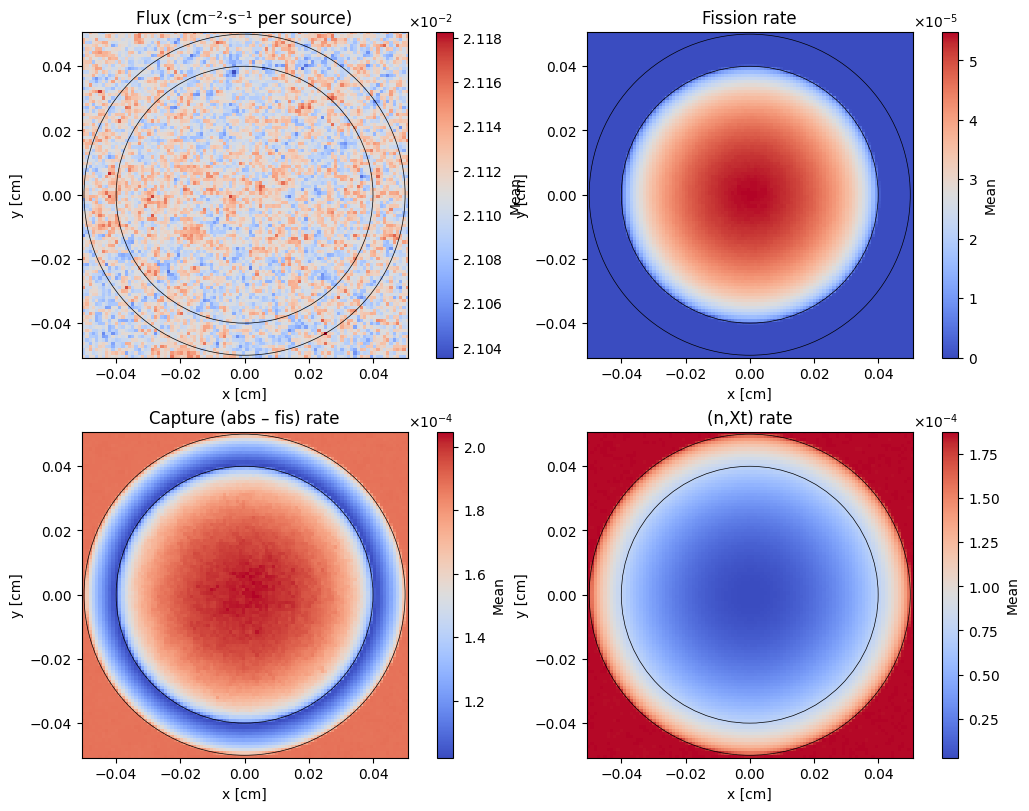

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.ticker as mticker


STATEPOINT = "./BISO_FLiBe_heterogeneous_50vol/statepoint.10.h5"   # 
sp = openmc.StatePoint(STATEPOINT)
tally = sp.get_tally(scores=['flux', 'fission', 'absorption', '(n,gamma)', '(n,Xt)', '(n,2n)'])
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])
absorption = tally.get_slice(scores=['absorption'])
tritium = tally.get_slice(scores=['(n,Xt)'])
n2n = tally.get_slice(scores=['(n,2n)'])

flux.std_dev.shape = (100, 100)
flux.mean.shape = (100, 100)

fission.std_dev.shape = (100, 100)
fission.mean.shape = (100, 100)

absorption.std_dev.shape = (100, 100)
absorption.mean.shape = (100, 100)

tritium.std_dev.shape = (100, 100)
tritium.mean.shape = (100, 100)

n2n.std_dev.shape = (100, 100)
n2n.mean.shape = (100, 100)

capture = absorption.mean - fission.mean
print(capture)

# --- map pixels to centimeters over the BISO diameter ---
R = cube_half  # cm
extent_cm = (-R, R, -R, R)  # (x_min, x_max, y_min, y_max)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

# Flux
im0 = axes[0].imshow(
    flux.mean,
    origin="lower",          # conventional Cartesian orientation
    extent=extent_cm,        # set axes in cm
    aspect="equal",          # square pixels in physical space
    cmap="coolwarm",
)
axes[0].add_patch(Circle((0.0, 0.0), radius=BISO_KERNEL_RADIUS, fill=False, linewidth=0.5))
axes[0].add_patch(Circle((0.0, 0.0), radius=BISO_RADIUS, fill=False, linewidth=0.5))
axes[0].set_title("Flux (cm⁻²·s⁻¹ per source)")
axes[0].set_xlabel("x [cm]")
axes[0].set_ylabel("y [cm]")
cb0 = plt.colorbar(im0, ax=axes[0], fraction=0.05, pad=0.001)
cb0.set_label("Mean")

# Fission
im1 = axes[1].imshow(
    fission.mean,
    origin="lower",
    extent=extent_cm,
    aspect="equal",
    cmap="coolwarm",
)
axes[1].add_patch(Circle((0.0, 0.0), radius=BISO_KERNEL_RADIUS, fill=False, linewidth=0.5))
axes[1].add_patch(Circle((0.0, 0.0), radius=BISO_RADIUS, fill=False, linewidth=0.5))
axes[1].set_title("Fission rate")
axes[1].set_xlabel("x [cm]")
axes[1].set_ylabel("y [cm]")
cb1 = plt.colorbar(im1, ax=axes[1], fraction=0.05, pad=0.001)
cb1.set_label("Mean")

# Capture
im2 = axes[2].imshow(
    capture, # absorption.mean,
    origin="lower",
    extent=extent_cm,
    aspect="equal",
    cmap="coolwarm",
)
axes[2].add_patch(Circle((0.0, 0.0), radius=BISO_KERNEL_RADIUS, fill=False, linewidth=0.5))
axes[2].add_patch(Circle((0.0, 0.0), radius=BISO_RADIUS, fill=False, linewidth=0.5))
axes[2].set_title("Capture (abs – fis) rate")
axes[2].set_xlabel("x [cm]")
axes[2].set_ylabel("y [cm]")
cb2 = plt.colorbar(im2, ax=axes[2], fraction=0.05, pad=0.001)
cb2.set_label("Mean")

# (n, Xt)
im3 = axes[3].imshow(
    tritium.mean,
    origin="lower",
    extent=extent_cm,
    aspect="equal",
    cmap="coolwarm",
)
axes[3].add_patch(Circle((0.0, 0.0), radius=BISO_KERNEL_RADIUS, fill=False, linewidth=0.5))
axes[3].add_patch(Circle((0.0, 0.0), radius=BISO_RADIUS, fill=False, linewidth=0.5))
axes[3].set_title("(n,Xt) rate")
axes[3].set_xlabel("x [cm]")
axes[3].set_ylabel("y [cm]")
cb3 = plt.colorbar(im3, ax=axes[3], fraction=0.05, pad=0.001)
cb3.set_label("Mean")

# (n, 2n)
# im4 = axes[4].imshow(
#     n2n.mean,
#     origin="lower",
#     extent=extent_cm,
#     aspect="equal",
#     cmap="coolwarm",
# )
# axes[4].add_patch(Circle((0.0, 0.0), radius=BISO_KERNEL_RADIUS, fill=False, linewidth=0.5))
# axes[4].add_patch(Circle((0.0, 0.0), radius=BISO_RADIUS, fill=False, linewidth=0.5))
# axes[4].set_title("(n,2n) rate")
# axes[4].set_xlabel("x [cm]")
# axes[4].set_ylabel("y [cm]")
# cb4 = plt.colorbar(im4, ax=axes[4], fraction=0.05, pad=0.001)
# cb4.set_label("Mean")

# --- colorbar scientific notation ---
for cb in (cb0, cb1, cb2, cb3, ): # cb4
    cb.formatter = mticker.ScalarFormatter(useMathText=True)
    cb.formatter.set_powerlimits((-2, 2))   # switch to 10^n when values <1e-2 or >1e2
    cb.update_ticks()

plt.show()
sp.close()

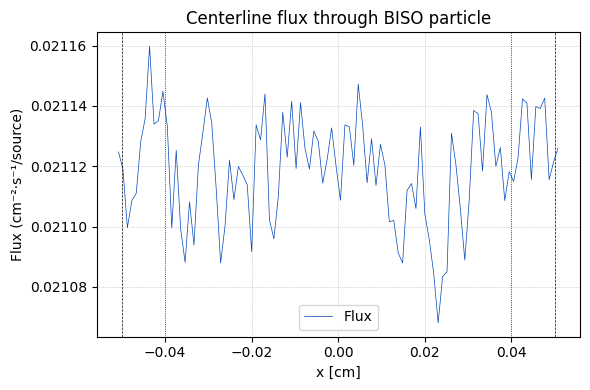

In [12]:
# flatten flux tally (already shaped 100×100)
flux_2d = flux.mean

# find center index (assuming even mesh → choose the mid plane)
ny, nx = flux_2d.shape
ix_center = nx // 2
iy_center = ny // 2

# 1D cuts
flux_x = flux_2d[iy_center, :]   # horizontal cut (y=0 line)
flux_y = flux_2d[:, ix_center]   # vertical cut (x=0 line)

# physical coordinates (in cm)
x = np.linspace(-R, R, nx)
y = np.linspace(-R, R, ny)

# plot centerline through y = 0
plt.figure(figsize=(6, 4))
plt.plot(x, flux_x, '-', color='#0047ba', label='Flux', lw=0.5)
plt.axvline(x=-BISO_RADIUS, color='k', ls='--', lw=0.5)
plt.axvline(x= BISO_RADIUS, color='k', ls='--', lw=0.5)
plt.axvline(x=-BISO_KERNEL_RADIUS, color='k', ls=':', lw=0.5)
plt.axvline(x= BISO_KERNEL_RADIUS, color='k', ls=':', lw=0.5)
plt.xlabel('x [cm]')
plt.ylabel('Flux (cm⁻²·s⁻¹/source)')
plt.title('Centerline flux through BISO particle')
plt.legend()
plt.grid(True, ls=':', lw=0.5)
plt.tight_layout()
plt.show()

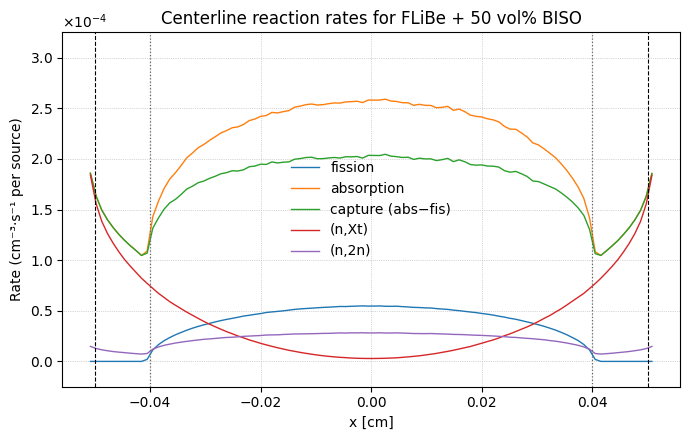

In [18]:
from matplotlib.ticker import ScalarFormatter

# --- extract data arrays ---
F   = np.asarray(fission.mean)
A   = np.asarray(absorption.mean)
Xt  = np.asarray(tritium.mean)
N   = np.asarray(n2n.mean)

# --- center indices ---
ny, nx = F.shape
iyc = ny // 2          # center row → y = 0
x = np.linspace(-R, R, nx)

# --- 1D centerline slices (y = 0) ---
fission_1d    = F[iyc, :]
absorption_1d = A[iyc, :]
capture_1d    = absorption_1d - fission_1d
tritium_1d    = Xt[iyc, :]
n2n_1d        = N[iyc, :]

# --- plot all on one figure ---
plt.figure(figsize=(7, 4.5))
plt.plot(x, fission_1d,    label='fission',            lw=1)
plt.plot(x, absorption_1d, label='absorption',         lw=1)
plt.plot(x, capture_1d,    label='capture (abs−fis)',  lw=1)
plt.plot(x, tritium_1d,    label='(n,Xt)',             lw=1)
plt.plot(x, n2n_1d,        label='(n,2n)',             lw=1)


# --- geometry markers ---
for xr in (-BISO_RADIUS, BISO_RADIUS):
    plt.axvline(xr, color='k', ls='--', lw=0.8)
for xr in (-BISO_KERNEL_RADIUS, BISO_KERNEL_RADIUS):
    plt.axvline(xr, color='0.4', ls=':', lw=0.9)

# --- axes labels & formatting ---
plt.xlabel('x [cm]')
plt.ylabel('Rate (cm⁻³·s⁻¹ per source)')
plt.title('Centerline reaction rates for FLiBe + 50 vol% BISO')

plt.ylim(-0.25e-4, 3.25e-4)

plt.grid(True, ls=':', lw=0.5)
plt.legend(ncol=1, frameon=False, loc='center')

# --- scientific notation for y-axis ---
fmt = ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-2, 2))
plt.gca().yaxis.set_major_formatter(fmt)

plt.tight_layout()
plt.savefig(f"fig_rr_flibe_vol50.png", bbox_inches='tight', format='png')
plt.show()